# 第3章 scikit-learnの活用
<div style="text-align: right;">date: 2019/06/08~14</div>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.metrics import accuracy_score
from decisionPlot import plot_decision_regions
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image, display_png
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## 1. scikit-learnを用いたパーセプトロンのトレーニング

### 1. データセットのロード
scikit-learnのデータベースからIrisデータセットをロードし、がくの長さと幅を特徴量として抽出する。

In [2]:
# データセットのロード
iris = datasets.load_iris()
# 3, 4行目を抽出し特徴行列Xとする
X = iris.data[:, [2, 3]]
# クラスラベルを取得
y = iris.target
# 特徴量行列の形状を確認
print("X shape: ", X.shape)
# クラスラベルが整数化されていることを確認
print("Class labels:", np.unique(y))

X shape:  (150, 2)
Class labels: [0 1 2]


### 2. データセットの前処理
モデルの性能を評価するためにデータセットをトレーニングデータセットとテストデータセットに分割する。
scikit-learnの`model_selection.train_test_split`を用いて分割を行う。

In [3]:
# 全体の30%をテストデータとする
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

最適な性能を得るために特徴量のスケーリングを行う。トレーニングデータセットから特徴量の平均$\mu$
と標準偏差$\sigma$を推定し、これを用いてトレーニングデータ、テストデータの両方をスケーリングする。トレーニングデータセットとテストデータセットを相互に比較できるようにするために同じパラメータを用いて標準化している。

$$
x'_{j} = \frac{x_{j} - \mu_{j}}{\sigma_{j}}
$$

scikit-learnでは`preprocessing`モジュールの`StandardScaler`クラスを使用して標準化を行う。

In [4]:
sc = StandardScaler()  # StandardScalerクラスの新しいインスタンスscを作成
sc.fit(X_train)  # トレーニングデータセットを使って平均と標準偏差を推定
# 推定した平均と標準偏差を用いてデータセットを標準化
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
# 各データの標準化を確認
print("Mean of X_train: ", np.mean(X_train, axis = 0))
print("Std of X_train: ", np.std(X_train, axis = 0))
print("Mean of X_train_std: ", np.mean(X_train_std, axis = 0))
print("Std of X_train_std: ", np.std(X_train_std, axis = 0))
print("Mean of X_test: ", np.mean(X_test, axis = 0))
print("Std of X_test: ", np.std(X_test, axis = 0))
print("Mean of X_test_std: ", np.mean(X_test_std, axis = 0))
print("Std of X_test_std: ", np.std(X_test_std, axis = 0))

Mean of X_train:  [3.78952381 1.19714286]
Std of X_train:  [1.79299822 0.76275904]
Mean of X_train_std:  [5.70971841e-17 7.19001578e-17]
Std of X_train_std:  [1. 1.]
Mean of X_test:  [3.68444444 1.20444444]
Std of X_test:  [1.67610071 0.75246426]
Mean of X_test_std:  [-0.05860539  0.0095726 ]
Std of X_test_std:  [0.93480333 0.98650323]


標準化した後のデータセットは$ \mu_{j} \approx 0$ , $\sigma_{j} \approx 1$ となっていることがわかる。

### 3. モデルのトレーニング
scikit-learnのほとんどのアルゴリズムでは多クラス分類がサポートされている。**一対多**(OvR)の手法が取られており、3つの品種のクラスをまとめてパーセプトロンに与えて分類を行うことができる。

In [5]:
# エポック数40, 学習率0.1のパーセプトロンモデルを作成
# エポック毎にトレーニングデータセットを並べ替える
ppn = Perceptron(max_iter = 10, eta0 = 0.1, random_state = 0, shuffle = True)
# モデルのトレーニング
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
           fit_intercept=True, max_iter=10, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

### 4. モデル性能の評価
トレーニングしたモデルを使ってテストデータセットについて予測を行う。

In [6]:
# 予測を実施
y_pred = ppn.predict(X_test_std)

# 誤分類数と正解率を表示
print('Misclassified samples: %d' % (y_test != y_pred).sum())

print("Accuracy: {:2.1%}".format(accuracy_score(y_test, y_pred)))  # sklearn.metrics.accuracy_scoreを用いて計算

Misclassified samples: 3
Accuracy: 93.3%


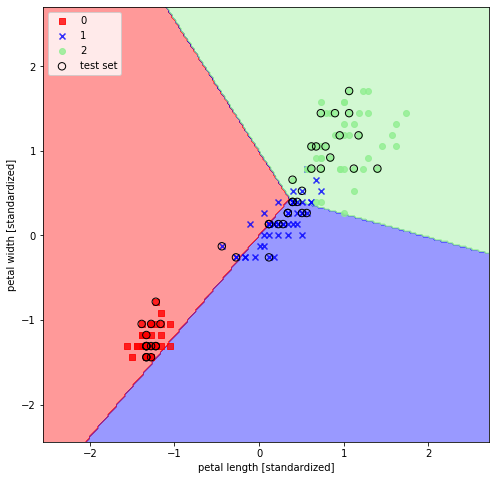

In [7]:
# トレーニングデータとテストデータを結合させる
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
# 決定領域のプロット
plt.figure(figsize = (8, 8))
plot_decision_regions(X = X_combined_std, y = y_combined, classifier = ppn, test_idx = range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc = 'upper left')

上図からわかるように決定境界を完全に決定することはできない。
完全な線形分離ができない場合、パーセプトロン分類器は収束しないため、実務では推奨されない。

## 2. ロジスティック回帰を用いたクラス分類モデル

### 1. ロジスティック回帰の概念

パーセプトロン分類器はクラスを完全に分離できない時には収束しない。なぜなら各エポックで少なくとも１つは誤って分類されるため、重みの更新が常に行われてしまうからである。
ロジスティック回帰は線形分離問題と二値分類問題に対する単純で強力なアルゴリズムであり、産業界で最も広く利用されている。二値分類のためのアルゴリズムを一対他手法に基づいて多クラス分類モデルへと拡張することができる。

以下では二値分類問題に関するロジスティック回帰モデルについて考える。
事象の起こりやすさを表す**オッズ比**はある事象が起こる確率を$p$として$\frac{p}{1-p}$と書くことができる。この事象についてクラスラベルを$y = 1$とすると以下のような**ロジット**(logit)関数を定義できる。

$$
logit(p) = \log{\frac{p}{1-p}}
$$

$logit(p)$は$0 \leq p \leq 1$なる$p$を受け取り実数を返す。この関数を使って特徴量と対数オッズの間の線形関係を表すことができる。

$$
logit(P(y = 1\mid\boldsymbol{x})) = w_{0}x_{0} + w_{1}x_{1} + \cdots + w_{m}x_{m} = \sum_{i=0}^{m}w_{i}x_{i} = \boldsymbol{w^{T}x}
$$

ここで$P(y = 1\mid\boldsymbol{x})$は$\boldsymbol{x}$が与えられた時にサンプルがクラス1に属する条件付き確率である。
実際にはサンプルが特定のクラスに属している確率を予測したいのでロジット関数の逆関数$\phi(\zeta)$を用いる。これは**ロジスティック**(logistic)関数と呼ばれる。特徴的なS字の概形から**シグモイド**(sigmoid)関数と呼ばれることもある。

$$
\phi(\zeta) = \frac{1}{1+e^{-\zeta}}
$$

$\zeta$は総入力で下式のような重みと特徴量の線型結合である。

$$
\zeta = \boldsymbol{w^{T}x} = w_{0} + w_{1}x_{1} + \cdots + w_{m}x_{m}
$$

下のコードでシグモイド関数`sigmoid(z)`を定義し、プロットしてみる。

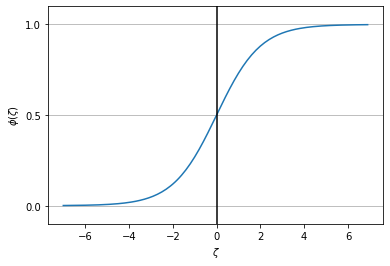

In [8]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# -7 ~ 7の範囲を0.1刻みで計算して描画
z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0.0, color = 'k')
plt.ylim(-0.1, 1.1)
plt.xlabel('$\zeta$')
plt.ylabel('$\phi (\zeta)$')
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

上図からわかるようにシグモイド関数は実数値$\zeta$を$\phi(\zeta) = 0.5$を切片とする$[0, 1]$の範囲の値に変換する。
ADALINE分類器の活性化関数は$\phi(\zeta) = \zeta$の恒等関数であったが、ロジスティック回帰モデルではこれがシグモイド関数になる。
特徴量$\boldsymbol{x}$が重み$\boldsymbol{w}$でパラメータ化されるとすると、シグモイド関数の出力$\phi(\zeta)$はサンプルがクラス1にする条件付き確率$P(y = 1\mid\boldsymbol{x};\boldsymbol{w})$であると解釈できる。例えば$\phi(\zeta) = 0.8$の時、このサンプルがクラス1に属する確率が0.8であることを意味している。従って分類器の出力にするためには以下の量子化器を使って変換すれば良い。

$$
\hat{y} = \begin{cases}
1 \quad \phi(\zeta) \geq 0.5 \\
0 \quad \phi(\zeta) < 0.5 \\
\end{cases}
$$

上図と合わせるとこれは以下と等価であるとわかる。

$$
\hat{y} = \begin{cases}
1 \quad \zeta \geq 0.0 \\
0 \quad \zeta < 0.5 \\
\end{cases}
$$

ロジスティック回帰では各サンプルのクラス所属関係の確率を見積もることができるため、広く使用されている。

### 2. ロジスティック関数の重みの学習
ADALINEの重み$\boldsymbol{w}$の最適化には下式で表される誤差平方和(SSE)を最小化した。

$$
J(\boldsymbol{w}) = \sum_{i}\frac{1}{2}(\phi(\zeta^{(i)}) - y^{(i)})^{2}
$$

データセットの各サンプルが互いに独立であると仮定して、ロジスティック回帰のコスト関数を導出する。ロジスティック回帰においては尤度$L$(結果から見た条件のもっともらしさ)を最大化することが目的となる。この尤度は下式で定義される。

$$
L(\boldsymbol{w}) = P(\boldsymbol{y} \mid \boldsymbol{x};\boldsymbol{w}) = \prod_{i=1}^{n}P(y^{(i)} \mid x^{(i)}; \boldsymbol{w}) = \prod_{i=1}^{n}(\phi(\zeta^{(i)}))^{y^{(i)}}(1 - \phi(\zeta^{(i)}))^{1-y^{(i)}}
$$

尤度のアンダーフロー可能性を減らし、微分をしやすくするために尤度の対数を取り、この対数尤度関数を最大化することでモデルをトレーニングする。

$$
l(\boldsymbol{w}) = \log{L(\boldsymbol{w})} = \sum_{i = 1}^{n} [y^{(i)} \log{(\phi(\zeta^{(i)}))} + (1 - y^{(i)})\log{(1 - \phi(\zeta^{(i)}}))]
$$

勾配上昇法を使って対数尤度関数$l(\boldsymbol)$を最大化しても良いが、対数尤度関数をコスト関数$J$として書き直し、ADALINE分類器で用いた勾配降下法を使って最小化できるようにする。

$$
J(\boldsymbol{w}) = \sum_{i = 1}^{n} [-y^{(i)} \log{(\phi(\zeta^{(i)}))} - (1 - y^{(i)})\log{(1 - \phi(\zeta^{(i)}}))]
$$

実際の分類において１つのサンプルで計算されるコストは以下のように表される。

$$
J(\phi(\zeta), y; \boldsymbol{w}) = \begin{cases}
-\log{(\phi(\zeta))} \quad (y = 1) \\
-\log{(1 - \phi(\zeta))} \quad (y = 0) \\
\end{cases}
$$

以下のグラフは様々な$\phi(\zeta)$の値に対する分類コストを示している。

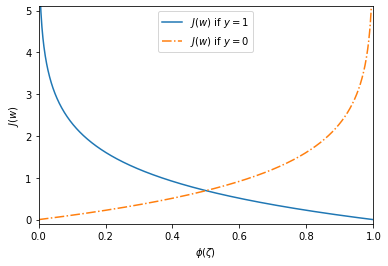

In [9]:
def likelihood_cost(phi_z, y):
    if y == 1:
        return -np.log(phi_z)
    else:
        return -np.log(1 - phi_z)

phi_z = np.arange(0.001, 1.0, 0.001)
cost_z1 = likelihood_cost(phi_z, 1)
cost_z0 = likelihood_cost(phi_z, 0)

plt.plot(phi_z, cost_z1, label = '$J(w)$ if $y = 1$')
plt.plot(phi_z, cost_z0, linestyle = 'dashdot', label = '$J(w)$ if $y = 0$')
plt.xlabel('$\phi(\zeta)$')
plt.ylabel('$J(w)$')
plt.xlim(0.0, 1.0)
plt.ylim(-0.1, 5.1)
plt.legend(loc = 'upper center')

上図からクラスへの所属確率の予測精度が高いほどコスト関数は0に近づくことがわかる。

### 3. scikit-learnを用いたロジスティック回帰モデルのトレーニング
`sklearn.liner_model.LogisticRegression`クラスと`fit`メソッドを使って標準化されたトレーニングデータでロジスティック回帰モデルをトレーニングする。

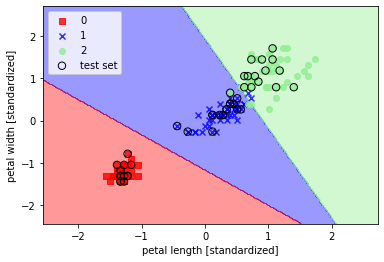

In [10]:
# ロジスティック回帰モデルのインスタンスを作成
lr = LogisticRegression(C = 1000.0, random_state = 1, multi_class = 'auto', solver = 'lbfgs')
# トレーニングデータにフィッティングさせる
lr.fit(X_train_std, y_train)
# 決定境界をプロット
plot_decision_regions(X_combined_std, y_combined, classifier = lr, test_idx = range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc = 'upper left')

In [11]:
# 予測を実施
y_pred = lr.predict(X_test_std)
# 誤分類数と正解率を表示
print('Misclassified samples: %d' % (y_test != y_pred).sum())

print("Accuracy: {:2.1%}".format(accuracy_score(y_test, y_pred)))  # sklearn.metrics.accuracy_scoreを用いて計算

Misclassified samples: 1
Accuracy: 97.8%


`predict_proba`メソッドを使ってサンプルの所属確率を予測することもできる。

In [12]:
lr.predict_proba(X_test_std[:3, :])

array([[1.31412372e-16, 8.89570135e-05, 9.99911043e-01],
       [9.98945705e-01, 1.05429541e-03, 2.05075813e-19],
       [9.99881982e-01, 1.18018083e-04, 9.17897848e-22]])

１つ目のサンプルがIris-Setosaに所属している確率が99.991
%であると予測したことがわかる。

勾配降下法に基づくロジスティック回帰モデルの重みの更新はADALINEで使用した式と同等である。
以下のようにしてこれを示す。
対数尤度関数を重みで偏微分すると以下のようになる。

$$
\frac{\partial}{\partial w_{j}} l(\boldsymbol{w}) = \left( y\frac{1}{\phi(\zeta)} - (1 - y)\frac{1}{1 - \phi(\zeta)}\right) \frac{\partial}{\partial w_{j}} \phi(\zeta)
$$

ここでロジスティック関数の偏導関数は下式なのでこれを代入して

$$
\frac{\partial}{\partial \zeta}\phi(\zeta) = \frac{\partial}{\partial \zeta}\frac{1}{1 + e^{-\zeta}} = \frac{1}{(1 + e^{-\zeta})^2}e^{-\zeta} = \frac{1}{1 + e^{-\zeta}}\left(1 - \frac{1}{1 + e^{-\zeta}}\right) = \phi(\zeta)(1 - \phi(\zeta))
$$

$$
\begin{split}
\left(y\frac{1}{\phi(\zeta)} - (1 - y)\frac{1}{1 - \phi(\zeta)}\right)\frac{\partial}{\partial w_{j}} \phi(\zeta) & = \left(y\frac{1}{\phi(\zeta)} - (1 - y)\frac{1}{1 - \phi(\zeta)}\right)\phi(\zeta)(1 - \phi(\zeta))\frac{\partial}{\partial w_{j}}\zeta \\
& = \left(y(1 - \phi(\zeta))-(1-y)\phi(\zeta)\right)x_{j} \\
& = (y - \phi(\zeta))x_{j} \\
\end{split}
$$

重み更新の一般式は以下のように表せる。ここで重みの更新量$\Delta\boldsymbol{w}$は$\Delta\boldsymbol{w} = \eta \nabla l(\boldsymbol{w})$である。

$$
\boldsymbol{w} := \boldsymbol{w} + \Delta\boldsymbol{w}
$$

対数尤度の最大化はコスト関数$J(\boldsymbol{w})$の最小化であるので、勾配降下法の更新規則は下式で表され、ADALINEの更新規則と一致する。

$$
\Delta w_{j} := -\eta \frac{\partial J}{\partial w_{j}} = \eta \sum_{i = 1}{n}\left(y^{(i)} - \phi(\zeta^{(i)})\right)x^{(i)}_{j}
$$

$$
\boldsymbol{w} := \boldsymbol{w} + \Delta \boldsymbol{w}, \Delta \boldsymbol{w} = - \eta \nabla J(\boldsymbol{w})
$$

### 4. 正則化による過学習への対処
**過学習**が起こると未知のデータについての予測が十分に行えない。過学習が発生しているモデルはバリアンスが高い(high variance)と呼ばれる。逆にトレーニングデータセットのパターンを捕捉するにはモデルの複雑さが十分でなく。未知データに対する性能が低くなることを**学習不足**という。このようなモデルはバイアスが高い(high bias)とも呼ばれる。
過学習や学習不足の問題は非線形の決定境界を求めるときによく現れる。
バリアンスはモデルのトレーニングを繰り返した際のモデルの予測の一貫性を表し、トレーニングデータのランダム性への敏感さを示す。また、バイアスはモデルを異なるトレーニングデータで構築した際に予測が正しい値からどの程度外れているかを表す。バイアスはランダム性によるものではなく、系統誤差の計測値である。
一般にモデルの汎化誤差は以下の式で表される。

$$
モデルの汎化誤差 = (バイアス)^{2} + バリアンス　+ ノイズ
$$

モデルの複雑さを調整する方法の１つとして**正則化**によってデータからノイズを取り除き、過学習を防ぐ方法がある。
正則化は特徴量の間の相関の高さである**共線性**を処理する非常に便利な手法であり、極端なパラメータの重みにペナルティを課すための追加情報(バイアス)を導入するものである。

最も一般的な正則化として**L2正則化**があり、次のように記述できる。

$$
\frac{\lambda}{2} \| \boldsymbol{w} \|^{2} = \frac{\lambda}{2} \sum_{j = 1}^{m} w_{j}^{2}
$$

正則化パラメータ$\lambda$は正則化パラメータであり、正則化の度合いを決定する。$\lambda$を大きくすると正則化の強さが高まる。
正則化を適用するには前述のコスト関数$J(\boldsymbol{w})$に正則化項を追加すればよく、以下の形のコスト関数となる。

$$
J(\boldsymbol{w}) = \sum_{i = 1}^{n} [-y^{(i)} \log{(\phi(\zeta^{(i)}))} - (1 - y^{(i)})\log{(1 - \phi(\zeta^{(i)}}))] + \frac{\lambda}{2} \| \boldsymbol{w} \|^{2}
$$

scikit-learnの`LogisticRegression`クラスに実装されているパラメータ`C`はサポートベクトルマシンの慣例に由来し、正則化パラメータの逆数を表す。
したがってコスト関数は下記のようになり、逆正則化パラメータ`C`の値を減らすことが正則化の強さを高めることとなる。正則化の強さを可視化するには2つの重み係数と逆正則化パラメータの関係をプロットすれば良い。

$$
J(\boldsymbol{w}) = C \sum_{i = 1}^{n} [-y^{(i)} \log{(\phi(\zeta^{(i)}))} - (1 - y^{(i)})\log{(1 - \phi(\zeta^{(i)}}))] + \frac{1}{2} \| \boldsymbol{w} \|^{2}
$$

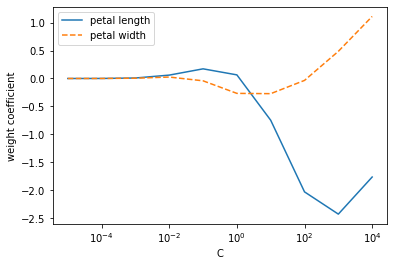

In [13]:
weights, params = [], []  # 重み、逆正則化パラメータを格納するリスト
# Cを10通りで試行し、ロジスティック回帰モデルをトレーニング
for c in np.arange(-5, 5):
    lr = LogisticRegression(C = 10.**c, random_state = 0,  solver = 'lbfgs', multi_class = 'auto')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)
weights = np.array(weights)

# 横軸に逆正則化パラメータ、縦軸に重み係数をプロット
plt.plot(params, weights[:, 0], label = 'petal length')
plt.plot(params, weights[:, 1], linestyle = '--', label = 'petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc = 'upper left')
plt.xscale('log')

## 3. サポートベクトルマシンによる分類
### 1. 最大マージンの考え方とサポートベクトルマシン
サポートベクトルマシンはパーセプトロンの拡張とみなすことができる。サポートベクトルマシンでは決定境界とそれに最も近いトレーニングサンプルとの距離を最大化(**マージンの最大化**)することを目標として学習を行う。このとき、分離超平面に最も近いトレーニングサンプルをサポートベクトルと呼ぶ。
決定境界に沿った**正**と**負**の超平面は下記のように表すことができる。

$$
w_{0} + \boldsymbol{w}^{T}\boldsymbol{x}_{pos} = 1 \\
w_{0} + \boldsymbol{w}^{T}\boldsymbol{x}_{neg} = -1
$$

上の２つの線形方程式を引き算すると次のようになる。

$$
\boldsymbol{w}^{T} ( \boldsymbol{x}_{pos} - \boldsymbol{x}_{neg}) = 2
$$

ここで以下のようにベクトルの長さ$\| \boldsymbol{w} \|$を定義して上式を標準化する。

$$
\| \boldsymbol{w} \| = \sqrt{\sum_{j = 1}^{m} w_{j}^{2}} \\
\frac{\boldsymbol{w}^{T} ( \boldsymbol{x}_{pos} - \boldsymbol{x}_{neg})}{\| \boldsymbol{w} \|}= \frac{2}{\| \boldsymbol{w} \|}
$$

この式の左辺は正の徴兵面と負の超平面の距離であると解釈できる。これが最大化したいマージンである。
サンプルが正しく分類されている、すなわち分離超平面が完全に分類できる超平面であるという制約のもとでSVMの目的関数を最大化する問題は$\frac{2}{\|\boldsymbol{w}\|}$の最大化すなわちマージンを最大化するという問題に帰着する。

$$
\begin{cases}
w_{0} + \boldsymbol{w}^{T}\boldsymbol{x}^{(i)} \geq 1 & (y^{(i)} = 1)\\
w_{0} + \boldsymbol{w}^{T}\boldsymbol{x}^{(i)} \geq -1 & (y^{(i)} = -1) \\
\end{cases} \\
i = 1 \cdots N
$$

上の2式はもっと簡潔に以下のようにもかける。

$$
y^{(i)}(w_{0} + \boldsymbol{w}^{T}\boldsymbol{x}^{(i)}) \geq 1 \quad \forall_{i}
$$

実際には$\frac{2}{\|\boldsymbol{w}\|}$の最大化よりも簡単である$\frac{1}{2}\|\boldsymbol{w}\|^{2}$の最小化を行う。これは二次計画法により解くことができる。

### 2. 線形分離が不可能なケース
上述の最大マージン分類には線形分離可能であるという制約があった。スラック変数$\xi$を使ってこの制約を緩和したモデルが**ソフトマージン分類**である。
SVMの制約条件に正値のスラック変数を導入して誤分類に対するペナルティを課した上で最適化問題を考える。

$$
\begin{cases}
w_{0} + \boldsymbol{w}^{T}\boldsymbol{x}^{(i)} \geq 1 - \xi^{(i)} & (y^{(i)} = 1)\\
w_{0} + \boldsymbol{w}^{T}\boldsymbol{x}^{(i)} \geq -1 + \xi^{(i)} & (y^{(i)} = -1) \\
\end{cases} \\
i = 1 \cdots N
$$

よって最小化したい対象は下式のようになる。

$$
\frac{1}{2} \|\boldsymbol{w}\|^{2} + C ( \sum_{i} \xi^{(i)} )
$$

変数`C`を変化させることで誤分類のペナルティを調整する。`C`の値が大きいとトレーニングデータを変えて学習、予測を行なっても結果の平均は真のクラスラベルに近くなるため、バイアスは小さくなる。代わりに学習のたびに予測値はばらつくため、バリアンスは高くなる。`C`の値を小さくするとこの逆になり、バイアスが大きく、バリアンスは小さくなる。
以下では`SVM`モデルのトレーニングを行なって`Iris`データセットの品種分類を行う。

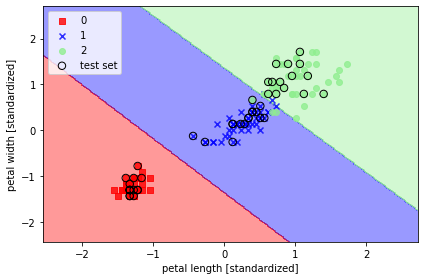

In [14]:
svm = SVC(kernel = 'linear', C = 1.0, random_state = 1)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier = svm, test_idx = range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc = 'upper left')
plt.tight_layout()

## 4. カーネルSVMを使った非線形問題の求解
SVMが高い人気を誇る理由に「**カーネル化**」が容易であることがある。以下では非線形分類がどのようなものなのかを確認し、 **カーネルSVM**を用いてこの分類問題を考えていく。

### 1. 線形分離不可能なデータとカーネル化
Numpyの`logical_xor`関数を使ってデータセットを作成する。このデータセットは[-1, 1]のクラスラベルを持つランダムなノイズを含んだ200個のXORデータセットである。

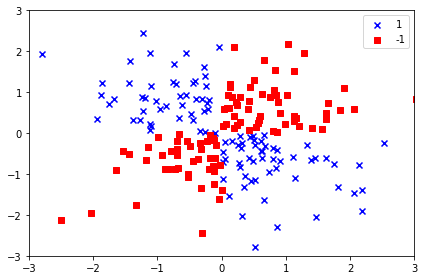

In [15]:
np.random.seed(1)  # 乱数のシードを指定
X_xor = np.random.randn(200, 2)  # 標準正規分布に従う200行2列の行列を作成
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)  # 排他的論理和の値が真の時は1, 偽のときは-1を割り当てる
# クラス1を青で、クラス2を赤でプロット
plt.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1], c = 'b', marker = 'x', label = '1')
plt.scatter(X_xor[y_xor == -1, 0], X_xor[y_xor == -1, 1], c = 'r', marker = 's', label = '-1')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc = 'best')
plt.tight_layout()

ここまでの線形ロジスティック回帰や線形SVMモデルを用いた場合、線形超平面の決定境界で陽性クラスと陰性クラスを分割することになるが、このデータセットに対してはうまくいかないことが明らかである。こうした線形分離できないデータを処理するカーネル手法の基本的な発想は射影関数$\phi$を使ってその組み合わせを高次元空間に射影し、線形分離できるようにすることである。2次元のデータセットを新しい3次元の特徴空間に変換し、クラスを分離する。例えば下記のような関数$\phi$で射影を行い、線形超平面で分割した後、元の空間に射影すると、非線形の分離境界が得られる。

$$
\phi(x_{1}, x_{2}) = (z_{1}, z_{2}, z_{3}) = (x_{1}, x_{2}, x_{1}^{2} + x_{2}^{2})
$$

### 2. カーネルトリックを使って分離超平面を高次元空間で特定する
SVMを使って非線形問題の解を求める時には射影関数$\phi$を用いてトレーニングデータセットを高次元空間に射影し、その空間内で線形SVMモデルをトレーニングする。新しい未知のデータに関しても同じ射影関数$\phi$を用いて高次元空間に射影し、線形SVMモデルを用いて分類できるようになる。
ただし、この射影手法には高次元のデータを扱う際に、計算コストが非常に高くなってしまうという問題がある。それを解決するために用いるのが「カーネルトリック」である。SVMをトレーニングする際の二次計画法におけるベクトルのドット積$\boldsymbol{x}^{(i)T}\boldsymbol{x}^{(j)}$を$\phi(\boldsymbol{x}^{(i)})^{T} \phi(\boldsymbol{x}^{(j)})$に置き換えるだけで良い。このドット積を二点間で陽に求めるとコストがかかるため、以下の「カーネル関数」を定義する。

$$
K(\boldsymbol{x}^{(i)}, \boldsymbol{x}^{(j)}) = \phi(\boldsymbol{x}^{(i)})^{T} \phi(\boldsymbol{x}^{(j)})
$$

最も広く使用されているカーネルの１つは以下の**動径基底関数カーネル**であり、「RBFカーネル」、「ガウスカーネル」とも呼ばれる。

$$
K(\boldsymbol{x}^{(i)}, \boldsymbol{x}^{(j)}) = \exp \left(- \frac{\| \boldsymbol{x}^{(i)} - \boldsymbol{x}^{(j)}\| ^{2}}{2\sigma^{2}} \right)
$$

多くの場合、簡略化されて次のようになる。

$$
K(\boldsymbol{x}^{(i)}, \boldsymbol{x}^{(j)}) = \exp \left(-\gamma \| \boldsymbol{x}^{(i)} - \boldsymbol{x}^{(j)}\| ^{2} \right)
$$

ここで$\gamma = \frac{1}{2\sigma^{2}}$は最適化されるハイパーパラメータである。
カーネルという言葉は大まかにいうと２つのサンプルの間の「類似性を表す関数」であると解釈できる。指数関数のべき乗部分が0からマイナス無限大の値を取ることで得られる類似度は1(全く同じサンプル)から0(全く違うサンプル)の範囲に収まる。
実装では上の`SVM`クラスのパラメータ`kernel = 'linear'`を`kernel = 'rbf'`に置き換えれば良い。

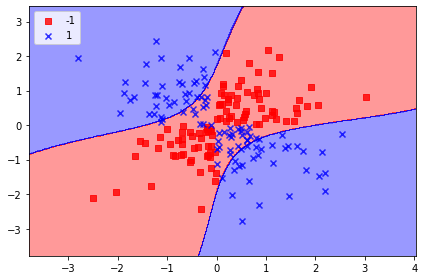

In [16]:
# RBFカーネルを用いたSVM
svm = SVC(kernel = 'rbf', C = 1.0, random_state = 1, gamma = 0.10)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier = svm)
plt.legend(loc = 'upper left')
plt.tight_layout()

$\gamma$パラメータ(`gamma = 0.10`)はこのカーネル関数の「カットオフ(限界値条件)」パラメータであると解釈できる。一般に$\gamma$パラメータを大きくするとトレーニングサンプルの影響が大きくなり、到達範囲が広くなる。それにより決定境界がより狭くなり、突出したようになる。
以下のように`Iris`データにRBFカーネルSVMを適用して$\gamma$が決定境界に与える影響を見てみる。

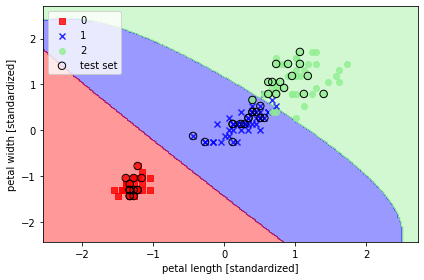

In [17]:
# gamma = 0.2の時
svm = SVC(kernel = 'rbf', C = 1.0, random_state = 1, gamma = 0.2)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier = svm, test_idx = range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc = 'upper left')
plt.tight_layout()

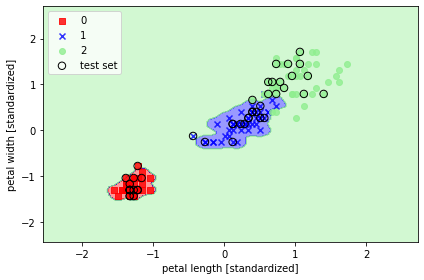

In [18]:
# gamma = 100.0の時
svm = SVC(kernel = 'rbf', C = 1.0, random_state = 1, gamma = 100.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier = svm, test_idx = range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc = 'upper left')
plt.tight_layout()

上図を見てもわかるように$\gamma$の値を大きくするとクラス0とクラス1の間の決定境界がかなり複雑になる。
トレーニングデータにはよく合致するが、未知のデータについては高い汎化誤差が生じることが考えられる。つまり、過学習に陥ってしまっているといえ、$\gamma$の最適化は過学習を防ぐ点でも重要な役割を果たしている。

## 5. 決定木学習
### 1. 決定木の概念
**決定木**(decision tree)分類器は意味解釈性(interpretability)に配慮する点で優秀なモデルである。決定木分類では一連の質問に基づいて決断を下す方法でデータを分類するモデルであると考えることができる。決定木モデルではトレーニングデータセットの特徴量に基づいて一連の質問を学習し、サンプルクラスラベルを推測する。カテゴリ変数に対する質問だけではなく、特徴量が実数である場合にも、しきい値を設定して二択質問をすることで分類していく。
決定木の根から始めて**情報利得**が最も大きい特徴量でデータを分割する。これを繰り返して葉が純粋になる(葉に含まれる全てのサンプルが同じクラスに属する)までデータを分割していく。実際には決定機が非常に多くのノードを持つ深い木になることがあるため、決定木の深さに一定の制限を設けて決定木を「剪定」(prune)する。

### 2. 情報利得の最大化
最も情報利得の高い特徴量でノードを分割するためには決定木学習アルゴリズムにおいて、最適化の対象となる目的関数を定義する必要がある。今回は分割ごとに情報利得(IG)が最大となるよう、以下のように定式化する。

$$
IG(D_{p}, f) = I(D_{p}) - \sum_{j = 1}^{m} \frac{N_{j}}{N_{p}} I(D_{j})
$$

ここで $f$は分割を行う特徴量であり、$D_{p}$は親のデータセット、$D_{j}$は$j$番目の子ノードのデータセットである。$I$は**不純度**を数値化したもので、$N_{p}$は親ノードのサンプル数、$N_{j}$は子ノードのサンプル数である。情報利得は「親ノードの不純度」と「子ノードの不純度の合計」の差をとったものであり、子ノードの不純度が低いほど情報利得は大きくなる。上式では$m$個の子ノードを対象としたが、単純化し、組み合わせ探索空間を減らすために、一般的には二分決定木が実装されている。親ノードは$D_{left}$と$D_{right}$の２つの子ノードに分割され、情報利得は次のように表される。

$$
IG(D_{p}, f) = I(D_{p}) - \frac{N_{left}}{N_{p}} I(D_{left}) - \frac{N_{right}}{N_{p}} I(D_{right})
$$

二分決定木によく使われる不純度には**ジニ不純度**と**エントロピー**と**分類誤差**の３つがあり、それぞれ$I_{G}$、$I_{H}$、$I_{E}$で表記する。
まず、空ではないクラス$i$を対象にエントロピーの定義をする。空ではないクラスとは$p(i \mid t) \neq 0$となるクラス$i$を表す。

$$
I_{H} (t) = - \sum_{j = 1}^{c} p(i \mid t) \log_{2} p(i \mid t)
$$

ここで$p(i \mid t)$は、特定のノード$t$においてクラス$i$に属するサンプルの割合を表す。よってノードに含まれるサンプルが全て同じクラスに属している時、エントロピーは0になる。二値分類においてエントロピーが0になるのは$p(i = 1 \mid t) = 1$または$p(i = 0 \mid t) = 0$の時である。逆にエントロピーが最大となるのは各クラスが一様に分布している時である。二値分類においてはクラスが$p(i = 1 \mid t) = 0.5$および$p(i = 0 \mid t) = 0.5$で一様に分布している場合である。よってエントロピーは「相互情報量が最大化するように試みる条件」と言える。
ジニ不純度は下記のように、誤分類の確率を最小化する条件であると解釈できる。

$$
I_{G}(t) = \sum_{i = 1}^{c} p(i \mid t)(1 - p(i \mid t)) = 1 - \sum_{i = 1}^{c} p(i \mid t)^{2}
$$

エントロピーと同様、ジニ不純度が最大になるのはグラフが完全に混合されている場合である。二値分類では以下のような時である。

$$
I_{G}(t) = 1 - \sum_{i = 0}^{c}0.5 ^ {2} = 0.5
$$

実際にはエントロピーとジニ不純度は非常に似た結果になるのが一般的である。したがって異なる不純度条件を使って決定木を評価するのに時間を割く必要はない。
不純度のもう１つの指標の分類誤差は以下の式で定義されている。

$$
I_{E}(t) = 1 - \max \{p(i \mid t) \}
$$

これは木の選定に役立つ条件だが、ノードのクラス確率の変化にあまり敏感でないので決定木を成長させるのには適していない。
三種類の不純度条件を視覚的に比較できるよう、クラス1の確率範囲$[0, 1]$に対する不純度の指標をプロットしてみる。エントロピーを2で割ったスケーリングバージョンも追加してジニ不純度がエントロピーと分類誤差の中間に位置付けられることも確認する。

Text(0, 0.5, 'Impurity Index')

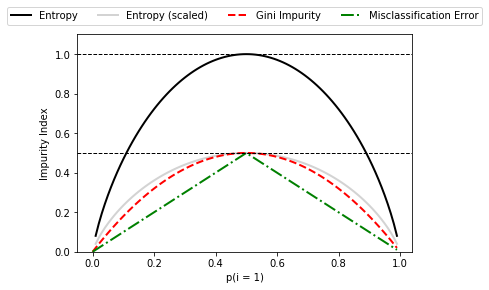

In [19]:
# ジニ不純度の関数
def gini(p):
    return (p) * (1 - p) + (1 - p)*(1 - (1 - p))

# エントロピーの関数
def entropy(p):
    return - p*np.log2(p) - (1 - p)*np.log2(1 - p)

# 分類誤差の関数
def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)  # 確率を表す配列

# 各不純度の計算
ent = [entropy(p) if p != 0 else None for p in x]  # entropyはp = 0の時にlog(p)が定義されないので除外する必要がある
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(p) for p in x]  # errorはリストを引数に取れない
gi = gini(x)  # giniはリストを引数に取れる

# 図の描画
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gi, err], ['Entropy', 'Entropy (scaled)', 'Gini Impurity', 'Misclassification Error'], 
                         ['-', '-', '--', '-.'], ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label = lab, linestyle = ls, lw = 2, color = c)
    
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.15), 
         ncol = 5, fancybox = True, shadow = False)
ax.axhline(y = 0.5, linewidth = 1, color = 'k', linestyle = '--')
ax.axhline(y = 1.0, linewidth = 1, color = 'k', linestyle = '--')
plt.ylim(0, 1.1)
plt.xlabel('p(i = 1)')
plt.ylabel('Impurity Index')

### 3. scikit-learnによる決定木の構築
決定木学習では特徴空間を矩形に分割することで複雑な決定境界を構築できる。しかし決定木が深くなるほどに決定境界が複雑になり、過学習に陥りやすくなることに注意しなければならない。以下ではscikit-learnを用いて最大の深さが4である決定木を構築し、トレーニングしてみる。特徴量のスケーリングは決定木モデルでは必ずしも必要ではない。なぜなら決定木学習ではしきい値を設定してそれとの大小関係で分割条件を決めるため、未スケーリングのデータセットでもスケーリング済みのデータセットでも、しきい値が変わるだけで分割自体には影響を及ぼさないからである。

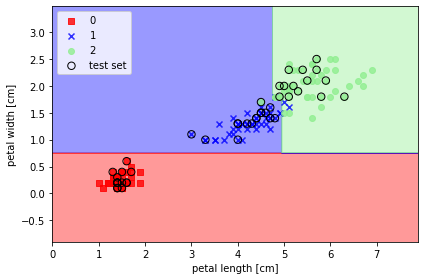

In [20]:
tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 4, random_state = 1)  # 決定木モデルの構築
tree.fit(X_train, y_train)  # モデルのトレーニング
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

# 決定境界のプロット
plot_decision_regions(X_combined, y_combined, classifier = tree, test_idx = range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc = 'upper left')
plt.tight_layout()

決定木分類に特有のものとして軸に平行な決定境界が得られていることがわかる。
scikit-learnにはトレーニング後の決定木を`.dot`ファイルとして出力できる機能がある。このファイルはGraphVizプログラムを使って可視化できる。また、GraphVizと同様の機能を持つ`pydotplus`というライブラリを用いることで`.dot`ファイルから決定木を表す画像ファイルを生成できる。

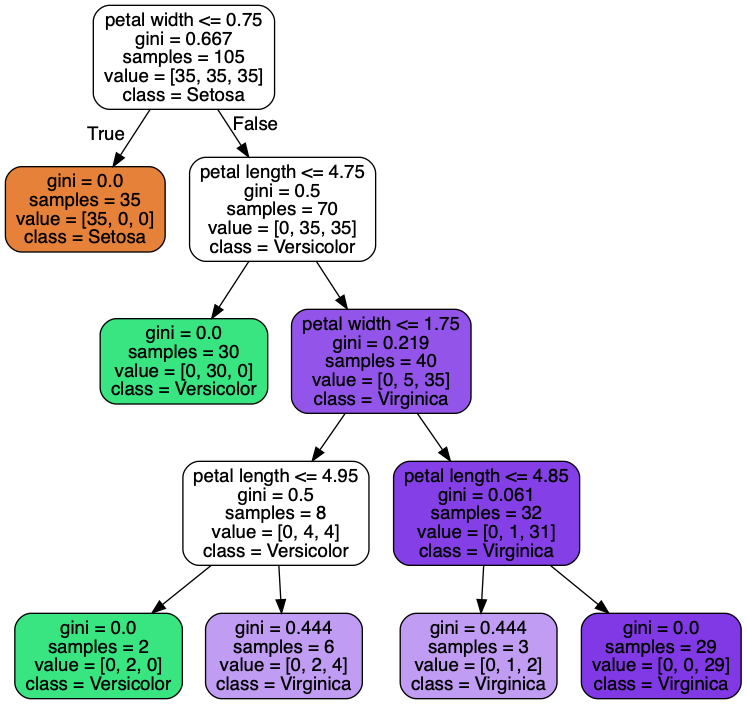

In [21]:
dot_data = export_graphviz(tree, filled = True, rounded = True, 
                          class_names = ['Setosa', 'Versicolor', 'Virginica'], 
                          feature_names = ['petal length', 'petal width'], 
                          out_file = None)  # out_file = Noneでファイルデータを書き出さず直接dot_dataに代入している
graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')
display_png(Image('tree.png'))

この決定木の画像から決定木がトレーニングデータセットから判定した分割を正確に辿ることができる。

### 4. ランダムフォレストを使って決定木を結合する
**ランダムフォレスト**は分類性能が良く、スケーラビリティに優れ使いやすいことから機械学習の応用において非常に支持されている。直感的には決定木の「アンサンブル」とみなせる。ランダムフォレストの背景の考え方はバリアンスの高い複数の木を平均化することで汎化性能の高い頑健なモデルを構築するというものである。このアルゴリズムは次の４つの手順にまとめることができる。

1. サイズ$n$のランダムな「ブートストラップ」標本を復元抽出する。
1. ブートストラップ標本から決定木を成長させる。各ノードで以下の作業を行う。
    1. $d$個の特徴量をランダムに非復元抽出する。
    1. 例えば情報利得を最大化することにより、目的関数に従って最適な分割となる特徴量を使ってノードを分割する。
1. 手順1, 2を$k$回繰り返す
1. 決定木ごとの予測をまとめて「多数決」に基づいてクラスラベルを割り当てる。

ここの決定木をトレーニングする時に比べて手順2に若干の変更がある。ノードごとに最適な分割を判断する際に全ての特徴量ではなくその一部をランダムに検討するだけとなっている。
ランダムフォレストには決定木と同じレベルの意味解釈性はない。ただしハイパーパラメータに適切な値を設定することについてあまり悩まなくて良いという利点がある。アンサンブルモデルはここの決定木のノイズにかなり強いため、通常はランダムフォレストを剪定する必要はない。実際に配慮すべきパラメータはランダムフォレストに対して選択する決定木の個数(手順3の$k$)の値だけである。一般に、決定木の個数が増えるほどモデルの性能は上がるが、計算コストが増える。
その他のパラメータ$n, d$については最適化が可能である(第5章参照)。ブートストラップの個数を小さくすると決定木同士の相違性が高くなる。特定のトレーニングサンプルが決定木に含まれる可能性が低くなるからである。このためブートストラップ標本のサイズを小さくするとランダムフォレストの「ランダム性」が大きくなり、結果として過学習を抑えるのに役立つことがある。ただし、ブートストラップ標本のサイズを小さくすると一般にはランダムフォレスト全体の性能は低くなる傾向にある。
scikit-learnの`RandomForestClassifier`実装をはじめとするほとんどの実装ではブートストラップ標本のサイズは元のトレーニングデータセットのサンプル数と同じになるように選択されている。これにより通常はバイアスとバリアンスが適切に調整される。各分割の特徴量の選択についてはトレーニングデータの特徴量の合計よりも小さい値を選択する必要がある。scikit-learnや他の実装で使用される妥当なデフォルト値は$d = \sqrt{m}$であり、$m$はトレーニングデータセットの特徴量の個数である。
以下でscikit-learnを用いたランダムフォレストの実装を行う。

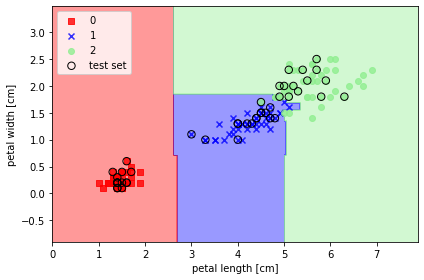

In [22]:
# ジニ不純度を指標とするランダムフォレストモデルの作成
# 決定木の個数: 25個, 並列処理数: 2
forest = RandomForestClassifier(criterion = 'gini', n_estimators = 25, random_state = 1, n_jobs = 2)
forest.fit(X_train, y_train)  # モデルのトレーニング

# 決定境界のプロット
plot_decision_regions(X_combined, y_combined, classifier = forest, test_idx = range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc = 'upper left')
plt.tight_layout()

## 6. k近傍法: 怠惰学習アルゴリズム

### 1. KNNの概要
本章で最後に取り上げるのは**k近傍法**、略して**KNN**である。KNNはこれまでに紹介したアルゴリズムとは根本的に異なるアルゴリズムである。KNNは**怠惰学習**の代表例である。「怠惰」と呼ばれるのはトレーニングデータから判別関数を学習するのではなく、トレーニングデータそのものを暗記するからである。
KNNの手順は以下のものである。

1. $k$の値と距離指標を選択する。
1. 分類したいサンプルから$k$個の最近傍データを見つける。
1. 多数決でラベルを割り当てる。

KNNアルゴリズムは選択された指標に基づきトレーニングデータセットのサンプルの中から分類したいデータに最も近い$k$個のサンプルを見つけ出す。新しいデータ点のクラスラベルは$k$個の最近傍での多数決できまる。こうしたメモリベースのアプローチの主な利点は新しいトレーニングデータを集めるとすぐに分類器が対応するという点である。一方最悪の場合、新しいサンプルを分類する際の計算量がトレーニングデータセットの数に比例して増加してしまうという欠点がある。ただし、トレーニングセットの次元が少なく、アルゴリズムが「KD木」などの効率的なデータ構造を用いていれば話は別である。さらに「トレーニング」ステップが存在しないため、トレーニングサンプルを破棄できない。このため、大きなデータセットを用いる際にはその記憶容量が問題になることもある。
以下でユークリッド距離の指標を使ってscikit-learnでKNNモデルを実装する。

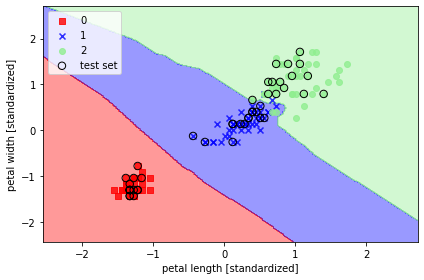

In [23]:
knn = KNeighborsClassifier(n_neighbors = 5, p = 2, metric = 'minkowski')  # KNNモデルの作成, k = 5
knn.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier = knn, test_idx = range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc = 'upper left')
plt.tight_layout()

$k$を正しく選択するには過学習と学習不足のバランスをうまく取ることが肝心である。また、データセットの特徴量に適した距離指標を選択することが大切である。一般に、実数値のサンプルにはユークリッド距離が用いられる。上のコードで使用した`minkowski`はマンハッタン距離とユークリッド距離を一般化したもので下記で表せる。パラメータ`p`を2に設定した時にはユークリッド距離、1に設定した時にはマンハッタン距離が与えられる。

$$
d(\boldsymbol{x}^{(i)}, \boldsymbol{x}^{(j)}) = \sqrt[p]{\sum_{k} \mid x_{k}^{(i)} - x_{k}^{(j)} \mid^{p}}
$$

> ### 次元の呪い  
**次元の呪い**とはデータサンプルの特徴量が増えるとともに特徴量空間が徐々にまばらになる現象のことである。高次元の空間では最近傍であっても離れすぎていてうまく予測できないことが想像できる。KNNや決定木のように正則化のできないモデルでは、特徴選択と次元削減の手法で次元の呪いから逃れることができる。

### 2. パラメトリック学習とノンパラメトリック学習
機械学習のアルゴリズムは大きく**パラメトリックモデル**と**ノンパラメトリックモデル**の２つに分けられる。パーセプトロン、ロジスティック回帰、線形SVMはパラメトリックモデルの典型例である。パラメトリックモデルはトレーニングデータからパラメータを学習し、それに基づいて新しいデータ点を分類する。
対照的に、決定木やKNNのようなノンパラメトリックモデルでは固定のパラメータ集合で特徴付けることは出来ない。パラメータの個数はトレーニングデータセットが増えるとともに増加する。
KNNはノンパラメトリックモデルに属し、「インスタンスに基づく学習」と呼ばれる。このモデルにはトレーニングデータを記憶するという特徴がある。怠惰学習は「インスタンスに基づく学習」の特殊な例であり、学習過程のコストは0である。

## 7. まとめ
本章では以下の分類アルゴリズムを扱った。

- パーセプトロン
    * 最もシンプルなモデル
- ロジスティック回帰
    * 事象の起こる確率を予測することが可能。
    * 確立的勾配法によるオンライン学習が可能。
- SVM
    * 強力な線形モデルであり、カーネルトリックで非線形問題を解くことも可能。
    * チューニングするパラメータの数が多い。
- 決定木
    * 結果の意味解釈性が高い。
    * 深さを適切に調整しないと過学習、学習不足に陥りやすい。
- ランダムフォレスト
    * アンサンブル手法であり、パラメータの調整が少なく済む。
    * 決定木ほど過学習に陥りやすくない。
- KNN
    * トレーニングデータセットをそのまま記憶するため、モデルのトレーニングが必要ない。
    * 予測時の計算コストがかかる。

各アルゴリズムに特徴があり、長所と短所がある。目的やデータセットに応じてこれらを適切に選択、調整していくことが大切である。